In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
from csvb.ingest import apply_rule, sel_factory, ApplyOp, SelectOp, AOP, SOP, Rule, to_transactions, strip_currency
import plotly.express as px
import plotly.graph_objects as go
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
def accounts(trans):
    return set(trans["From"]).union(set(trans["To"]))

def read_and_apply(df, rulepth, debug=False):
    with open(rulepth) as f:
        for rule in tml.load(f)["rules"]:
            if debug:
                print(rule)
            apply_rule(Rule(**rule), df)
    return df
    

In [3]:
home = pathlib.Path.home()
cfgpth = home / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
cfg

{'title': 'csvb config',
 'paths': {'path': 'als/csvbdata/',
  'bank': 'als/csvbdata/bank',
  'products': 'als/csvbdata/products/',
  'rules': 'als/csvbdata/rules/'}}

In [4]:
try:
    del apl
except NameError:
    pass

apl = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_Apple_CC.csv",
                    header=0, parse_dates=["Transaction Date", "Clearing Date"])

apl = apl.rename(columns={"Amount (USD)": "Amount"})
apl["Amount"] = -1 * apl["Amount"]
apl["From"] = ""

apl = read_and_apply(apl, home / cfg["paths"]["rules"] / "aplrules.toml")
#apl

Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b='Banana Republic')], apply=[ApplyOp(op='assign', column='From', b='Expenses:Clothing')])
Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b='Apple Services')], apply=[ApplyOp(op='assign', column='From', b='Expenses:Subscription')])
Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b='Phillips 66')], apply=[ApplyOp(op='assign', column='From', b='Expenses:Auto:Gas')])
Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b='Ridge Wallet')], apply=[ApplyOp(op='assign', column='From', b='Expenses:Gear')])
Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b="Martin's Supermarket")], apply=[ApplyOp(op='assign', column='From', b='Expenses:Groceries')])
Rule(select=[SelectOp(op='contains', column='Merchant', a='None', b='Apple Cash Payment')], apply=[ApplyOp(op='assign', column='From', b='Income:Apple Cash')])
Rule(select=[SelectOp(op='contains', column='Merchant', a

In [5]:
try:
    del fst
except NameError:
    pass

fst = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_1st.csv",
                    header=3, parse_dates=["Date"])

fst_old = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "2021-2023_1st_source.csv",
                    header=3, parse_dates=["Date"])

fst_older = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "2021-2022_1st_source.csv",
                    header=3, parse_dates=["Date"])

fst = pd.concat([fst, fst_old, fst_older])

fst["Amount"] = np.nansum([fst["Amount Credit"],fst["Amount Debit"]], axis=0)
fst["From"] = ""

fst = read_and_apply(fst, home / cfg["paths"]["rules"] / "fstrules.toml")
fst[fst["From"] == ""]

Rule(select=[SelectOp(op='contains', column='Description', a='None', b='crossfit south'), SelectOp(op=<built-in function ne>, column='Amount', a='None', b=-225.0)], apply=[ApplyOp(op='assign', column='From', b='Expenses:Groceries')])
Rule(select=[SelectOp(op='contains', column='Description', a='None', b='APPLE STOR'), SelectOp(op=<built-in function eq>, column='Amount', a='None', b=481.4)], apply=[ApplyOp(op='assign', column='From', b='Transfer:Apple:Installments')])
Rule(select=[SelectOp(op='contains', column='Description', a='None', b='crossfit south'), SelectOp(op=<built-in function eq>, column='Amount', a='None', b=-225.0)], apply=[ApplyOp(op='assign', column='From', b='Expenses:Fitness:ID')])
Rule(select=[SelectOp(op='contains', column='Description', a='None', b='INDIGO GARDENS')], apply=[ApplyOp(op='assign', column='From', b='Expenses:Home:Maintenance')])
Rule(select=[SelectOp(op='contains', column='Description', a='None', b='ND PAYROLL')], apply=[ApplyOp(op='assign', column='Fro

,Transaction Number,Date,Description,Memo,Amount Debit,Amount Credit,Balance,Check Number,Fees,Amount,From
0,NaN,2021-12-31,Initial Balance,Manual KWD,NaN,5067.54,5067.54,NaN,NaN,5067.54,
56,20220520000000[-5:EST]*481.50*542**DDA RTN APP...,2022-05-20,DDA RTN APPLE STOR,6501 N. GRAPE ROAD MISHAWAKA IN 214015264080,NaN,481.50,2136.48,NaN,NaN,481.50,


In [6]:
try:
    del ally
except NameError:
    pass
:q
ally = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_Ally.csv",
                    header=0, parse_dates=["Date"])

ally["From"] = ""
ally = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))

ally = read_and_apply(ally, home / cfg["paths"]["rules"] / "allyrules.toml")
#ally

In [7]:
try:
    del ndfcu
except NameError:
    pass

ndfcu = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_NDFCU_CC.csv",
                    header=0, names=["Date", "Note", "Description", "Amount", "Balance"],
                    parse_dates=["Date"])

ndfcu["From"] = ""
ndfcu["Amount"] = ndfcu["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
ndfcu = read_and_apply(ndfcu, home / cfg["paths"]["rules"] / "ndfcurules.toml")
#ndfcu

In [10]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu}


trans = to_transactions(bank_tables)
trans.sort_values("Date")

,Date,Description,Amount,From,To
0,2022-09-26,ATM W/D 1ST SOURCE,-100.00,Expenses:Cash,Assets:1st Source:Checking
1,2022-09-26,crossfit south b crossfit s,-225.00,Expenses:Groceries,Assets:1st Source:Checking
2,2022-09-30,ND PAYROLL PAYROLL,5160.66,Income:Notre Dame:Regular,Assets:1st Source:Checking
3,2022-09-30,APPLECARD GSBANK PAYMENT,-4397.88,Transfer:Apple:Credit Card,Assets:1st Source:Checking
4,2022-10-03,DOVENMUEHLE MTG MORTG PYMT,-702.96,Expenses:Home:Mortgage,Assets:1st Source:Checking
...,...,...,...,...,...
300,2024-01-31,MONTHLY INSTALLMENTS (21 OF 24),-54.12,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card
301,2024-01-31,MONTHLY INSTALLMENTS (21 OF 24),-8.29,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card
302,2024-01-31,APPLE CASH PAYMENT,40.45,Income:Apple Cash,Liabilities:Apple:Credit Card
303,2024-01-31,ND PAYROLL PAYROLL,5335.70,Income:Notre Dame:Regular,Assets:1st Source:Checking


In [30]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])

#bal_decl["From"] = ""
#bal["Amount"] = bal["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
#bal_decl = bal_decl.sort_values("Date")
#bal_decl
#jan_bal = bal_decl.loc[(bal_decl["Date"] >= pd.Timestamp(2023, 12, 31)) &
#                       (bal_decl["Date"] <= pd.Timestamp(2024, 1, 1))
#trans = pd.concat([trans, bal_decl])
bal_decl

,Date,Account,Statement Balance
0,2022-12-31,Liabilities:NDFCU:Credit Card,-76.69
1,2023-11-30,Liabilities:NDFCU:Credit Card,-2085.08
2,2023-10-31,Liabilities:NDFCU:Credit Card,-2492.89
3,2023-09-30,Liabilities:NDFCU:Credit Card,-1581.47
4,2023-08-31,Liabilities:NDFCU:Credit Card,-69.79
5,2023-07-31,Liabilities:NDFCU:Credit Card,-3172.26
6,2023-06-30,Liabilities:NDFCU:Credit Card,-1409.14
7,2023-05-31,Liabilities:NDFCU:Credit Card,-351.48
8,2023-04-30,Liabilities:NDFCU:Credit Card,-3924.01
9,2023-03-31,Liabilities:NDFCU:Credit Card,-2519.52


In [31]:
def create_ledgers(trans):
    """ Create a ledger for each account of all from / to transactions and create balance / time column.
    'Transaction Pair' is a terrible name, but it reminds that this is 1 half of a known transation for use
    as a ledger of an account and running balance calculation.
    All values appended from the "From" side of a transaction are reversed here, because a positive value
    "From" this account subtracts from it's balance.
    
    """
    # TODO: Add an option of a start of / end of period dates. Automatically calculate balance at
    # beginning of period.
    # TODO: Add processing of balance assertions to allow checks and reconciliation.
    
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    ledgers = {}
    for acct in accounts(trans):
        # From accounts, note the negative applied to Amount.
        try:
            df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
            df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
            ledgers[acct] = df
        # If account is not in From group, skip.
        except KeyError:
            pass

        # To accounts.

        try:
            df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
            df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
            try:
                ledgers[acct] = pd.concat([ledgers[acct], df])
            # If account was not also in From accounts list, don't concat.
            except KeyError:
                ledgers[acct] = df
        # If account is not in list To accounts, skip.
        except KeyError:
            pass
            
        # Sort and apply cumulative sum.
        ledgers[acct] = ledgers[acct].sort_values("Date")
        ledgers[acct]["Balance"] = ledgers[acct]["Incoming Amount"].cumsum()

    return ledgers

def trans_to_ledger(trans, acct, bal_decl = None, clean=False, leq=True):
    """ Craete a single ledger. This is a step to using ledgers as a view on the transactions rather than
    a precalcualted object.
    
    """   
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    #ledgers = {}
    #for acct in accounts(trans):
    # From accounts, note the negative applied to Amount.
    try:
        df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
        df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
        ledger = df
        # If account is not in From group, skip.
    except KeyError:
        pass

    # To accounts.

    try:
        df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
        df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
        try:
            ledger = pd.concat([ledger, df])
        # If account was not also in From accounts list, don't concat.
        except (NameError, UnboundLocalError):
            ledger = df
    # If account is not in list To accounts, skip.
    except KeyError:
        pass
    if clean:
        ledger = clean_ledger(ledger)        
    # Sort and apply cumulative sum.
    
    if bal_decl is not None:
        ledger = append_init_row(ledger, acct, bal_decl, leq=leq)
    ledger = ledger.sort_values("Date")
    ledger["Balance"] = ledger["Incoming Amount"].cumsum()

    return ledger

def clean_ledger(ledger):
    """Remove transactions occurring before the last transaction with all accounts assigned.
    Intended to catch incomplete data and return a useful ledger set on a per account basis.
    """
    #clean = {}
    #for acct in ledgers:
    try:
        clean = ledger.loc[[ledger["From"] == ""]:,:]
    except KeyError:
        clean = ledger
        
    return clean

def init_balance(bal_decl, acct, first_date, leq=False):
    #first_date = min(ledger["Date"])
    if leq:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] <= first_date)]
    else:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] < first_date)]
    
    # Catch indexerror if no balance found.
    try:
        return acct_balances.sort_values("Date").iloc[-1]
    except IndexError:
        return None

def append_init_row(ledger, acct, bal_decl, leq=False):
    #print(acct)
    #print(ledger)
    # Find proper initial balance.
    init = init_balance(bal_decl, acct, min(ledger["Date"]), leq=leq)

    # Skip if no appropriate balance was found.
    if init is not None:
        
        # Create df of initial balance row.
        decl_to_ledg_col = {"Statement Balance": "Incoming Amount", "Account": "Transaction Pair"}
        init_df = pd.DataFrame(init).T.rename(columns=decl_to_ledg_col)
        init_df["Description"] = "Initial Balance"

        # Add to first row, make sure we are sorted before recalculating balance column.
        ledger = pd.concat([init_df, ledger]).sort_values("Date")
        ledger["Balance"] = ledger["Incoming Amount"].cumsum()
    return ledger  
        

#ledgers = create_ledgers(trans)
ledgers = {}
for acct in accounts(trans):
    ledgers[acct] = trans_to_ledger(trans, acct, bal_decl=bal_decl, clean=True)

In [32]:
bals = []
firstds = []
lastds = []
initbals = []

for acct in ledgers:
    bals.append(ledgers[acct]["Incoming Amount"].sum())
    firstds.append(ledgers[acct]["Date"].iloc[0])
    lastds.append(ledgers[acct]["Date"].iloc[-1])
    initial = ledgers[acct].loc[ledgers[acct]["Description"] == "Initial Balance"]
    if len(initial) != 0:
        initbals.append(initial["Balance"].iloc[0])
    else:
        initbals.append(0)
    #initbals.append(ledgers[acct]["Balance"].iloc[0])
    
acct_bals = pd.DataFrame({"Period Start": firstds,
                          "Initial Balance": initbals,
                          "Period End": lastds,
                          "Ending Balance": bals},
                         index = ledgers.keys())
acct_bals.index.name = "Account"


In [33]:
acct_bals["Difference"] = acct_bals["Ending Balance"] - acct_bals["Initial Balance"]
acct_bals

,Period Start,Initial Balance,Period End,Ending Balance,Difference
Account,,,,,
,2022-09-26,0.00,2023-10-24,-1037.39,-1037.39
Income:Notre Dame:Regular,2022-09-30,0.00,2024-01-31,-92390.59,-92390.59
Expenses:Home:Mortgage,2022-10-03,0.00,2024-01-02,11552.70,11552.70
Income:Interest,2022-10-24,0.00,2024-01-30,-72.87,-72.87
Expenses:Home:Cleaning,2024-01-17,0.00,2024-01-17,278.00,278.00
Expenses:Subscriptions,2023-12-31,0.00,2024-01-30,55.97,55.97
Liabilities:Apple:Installments,2023-12-31,-312.21,2024-01-31,-249.80,62.41
Expenses:Subscription,2024-01-01,0.00,2024-01-29,114.83,114.83
Expenses:Gear,2024-01-24,0.00,2024-01-24,101.65,101.65


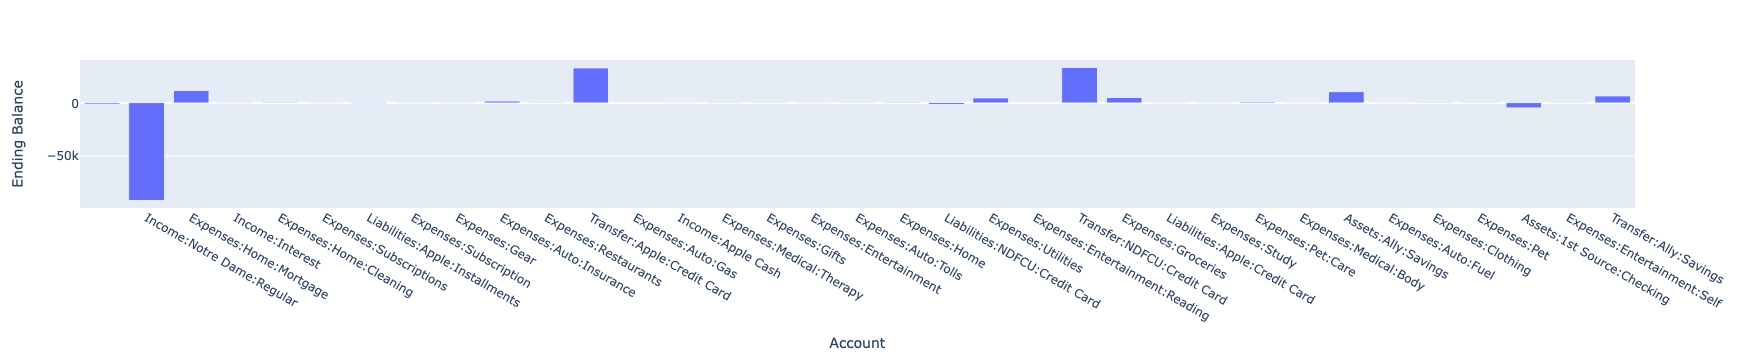

In [34]:
fig = px.bar(acct_bals, x=acct_bals.index, y="Ending Balance")
fig.show()

In [35]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])

In [36]:
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))
flow_df

Amount
From                          To                                      
                              Assets:1st Source:Checking       5344.99
Assets:1st Source:Checking                                     4307.60
                              Expenses:Auto:Insurance          1597.15
                              Expenses:Gifts                    125.00
                              Expenses:Groceries               4887.00
                              Expenses:Home:Mortgage          11552.70
                              Expenses:Pet:Care                 720.00
                              Expenses:Utilities               4250.05
                              Liabilities:Apple:Credit Card    2315.13
                              Transfer:Ally:Savings            9600.00
                              Transfer:Apple:Credit Card      32866.90
                              Transfer:NDFCU:Credit Card      33507.17
Assets:Ally:Savings           Transfer:Ally:Savings            1000.00
Expenses:Groceries            Assets:1st Source:Checking        337.50
Expenses:Medical:Body         Liabilities:NDFCU:Credit Card      76.50
Income:Apple Cash             Liabilities:Apple:Credit Card      40.45
Income:Interest               Assets:1st Source:Checking          3.92
                              Assets:Ally:Savings                68.95
Income:Notre Dame:Regular     Assets:1st Source:Checking      92390.59
Liabilities:Apple:Credit Card Expenses:Auto:Gas                   8.43
                              Expenses:Auto:Tolls               127.50
                              Expenses:Clothing                 481.50
                              Expenses:Entertainment             56.18
                              Expenses:Entertainment:Reading     12.99
                              Expenses:Entertainment:Self       142.54
                              Expenses:Gear                     101.65
                              Expenses:Groceries                453.69
                              Expenses:Home:Cleaning            278.00
                              Expenses:Medical:Body              38.96
                              Expenses:Restaurants                1.50
                              Expenses:Study                     77.92
                              Expenses:Subscription             114.83
                              Expenses:Utilities                175.12
                              Liabilities:Apple:Installments     62.41
Liabilities:NDFCU:Credit Card Expenses:Auto:Fuel                 31.94
                              Expenses:Groceries                226.65
                              Expenses:Home                     237.35
                              Expenses:Medical:Body              68.39
                              Expenses:Medical:Therapy          132.46
                              Expenses:Pet                      542.78
                              Expenses:Restaurants              146.58
                              Expenses:Subscriptions             55.97
                              Expenses:Utilities                107.05
Transfer:Ally:Savings         Assets:1st Source:Checking       3000.00
                              Assets:Ally:Savings              1200.00

In [37]:
accts = list(accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )

labels

['',
 'Income:Notre Dame:Regular',
 'Expenses:Home:Mortgage',
 'Income:Interest',
 'Expenses:Home:Cleaning',
 'Expenses:Subscriptions',
 'Liabilities:Apple:Installments',
 'Expenses:Subscription',
 'Expenses:Gear',
 'Expenses:Auto:Insurance',
 'Expenses:Restaurants',
 'Transfer:Apple:Credit Card',
 'Expenses:Auto:Gas',
 'Income:Apple Cash',
 'Expenses:Medical:Therapy',
 'Expenses:Gifts',
 'Expenses:Entertainment',
 'Expenses:Auto:Tolls',
 'Expenses:Home',
 'Liabilities:NDFCU:Credit Card',
 'Expenses:Entertainment:Reading',
 'Liabilities:Apple:Credit Card',
 'Transfer:NDFCU:Credit Card',
 'Expenses:Groceries',
 'Expenses:Utilities',
 'Expenses:Study',
 'Assets:Ally:Savings',
 'Expenses:Medical:Body',
 'Expenses:Pet:Care',
 'Expenses:Auto:Fuel',
 'Expenses:Clothing',
 'Expenses:Pet',
 'Assets:1st Source:Checking',
 'Expenses:Entertainment:Self',
 'Transfer:Ally:Savings']

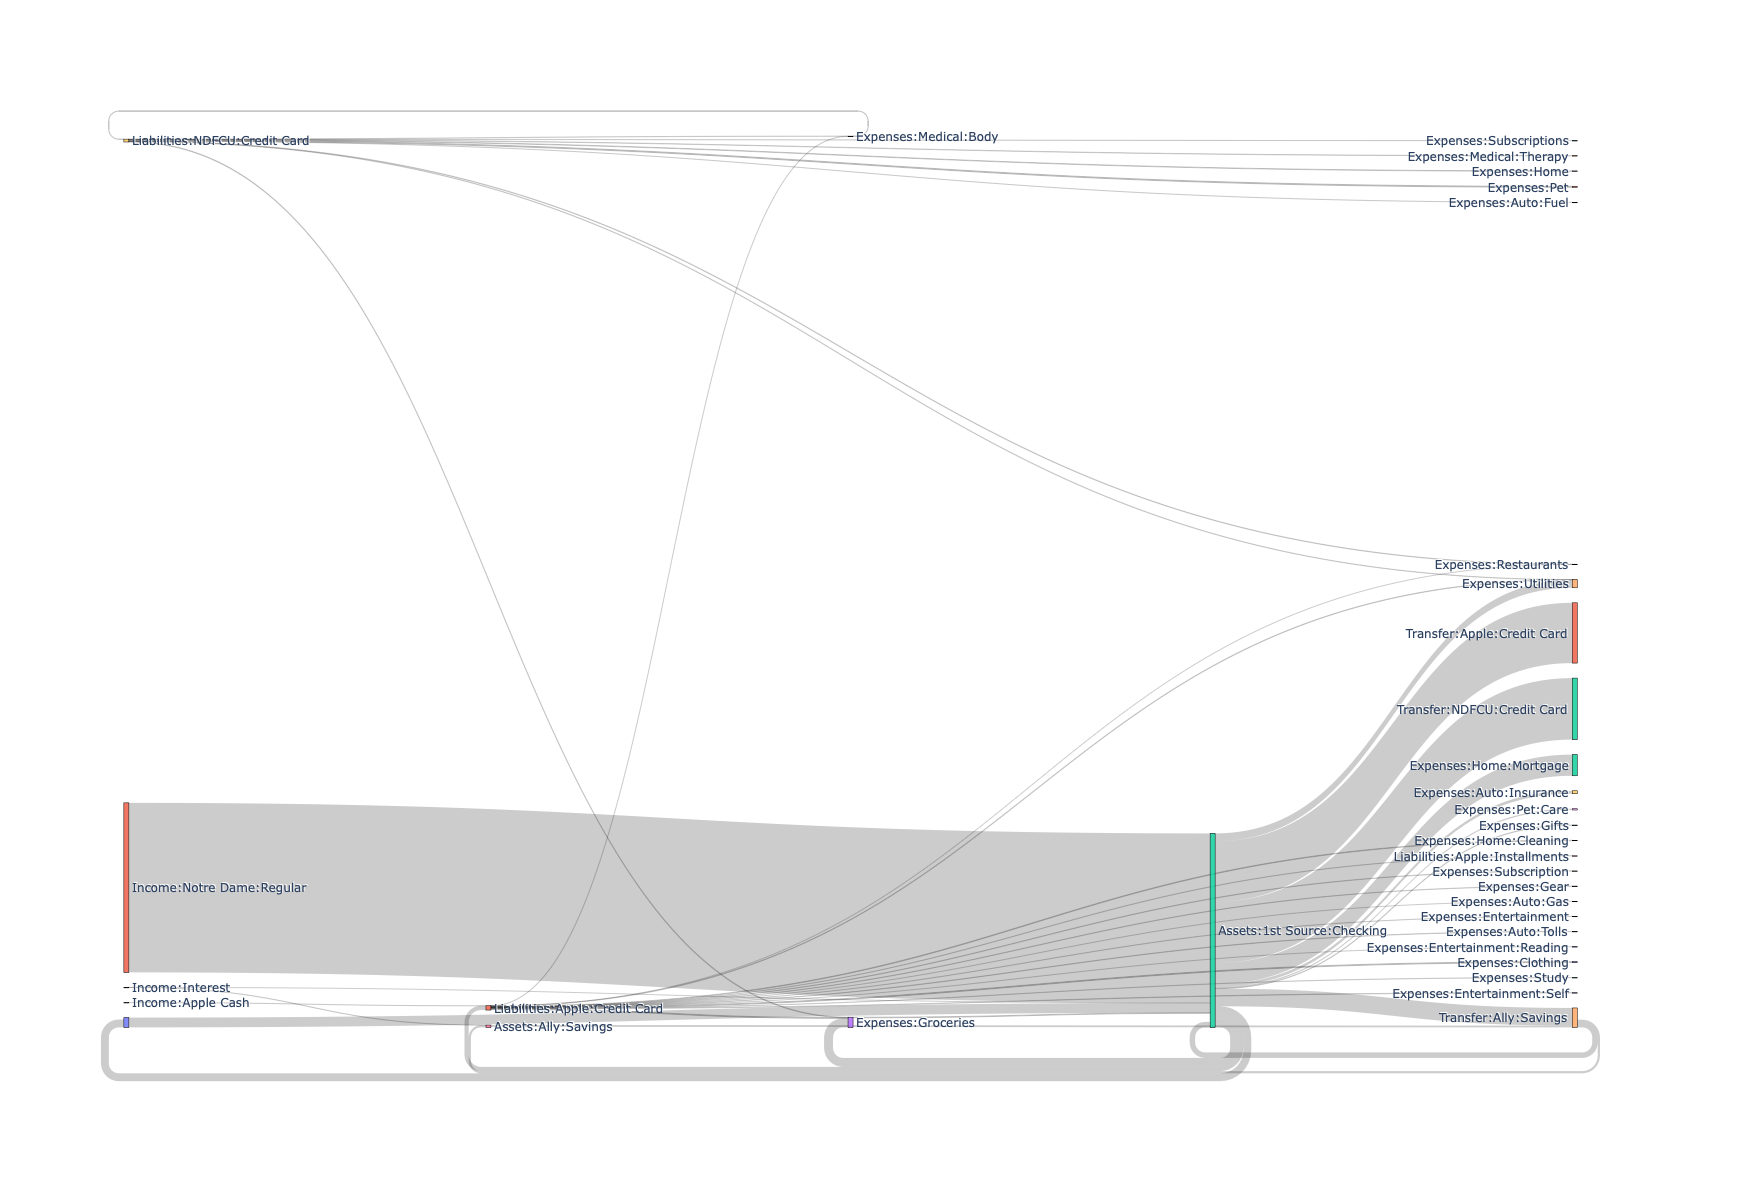

In [38]:
f.update_layout(height=1200)
f.show()

In [39]:
print(list(zip(sources, targets)))
print(list(zip([accts[s] for s in sources], [accts[t] for t in targets])))

[
    (0, 32),
    (32, 0),
    (32, 9),
    (32, 15),
    (32, 23),
    (32, 2),
    (32, 28),
    (32, 24),
    (32, 21),
    (32, 34),
    (32, 11),
    (32, 22),
    (26, 34),
    (23, 32),
    (27, 19),
    (13, 21),
    (3, 32),
    (3, 26),
    (1, 32),
    (21, 12),
    (21, 17),
    (21, 30),
    (21, 16),
    (21, 20),
    (21, 33),
    (21, 8),
    (21, 23),
    (21, 4),
    (21, 27),
    (21, 10),
    (21, 25),
    (21, 7),
    (21, 24),
    (21, 6),
    (19, 29),
    (19, 23),
    (19, 18),
    (19, 27),
    (19, 14),
    (19, 31),
    (19, 10),
    (19, 5),
    (19, 24),
    (34, 32),
    (34, 26)
]

[
    ('', 'Assets:1st Source:Checking'),
    ('Assets:1st Source:Checking', ''),
    ('Assets:1st Source:Checking', 'Expenses:Auto:Insurance'),
    ('Assets:1st Source:Checking', 'Expenses:Gifts'),
    ('Assets:1st Source:Checking', 'Expenses:Groceries'),
    ('Assets:1st Source:Checking', 'Expenses:Home:Mortgage'),
    ('Assets:1st Source:Checking', 'Expenses:Pet:Care'),
    ('Assets:1st Source:Checking', 'Expenses:Utilities'),
    ('Assets:1st Source:Checking', 'Liabilities:Apple:Credit Card'),
    ('Assets:1st Source:Checking', 'Transfer:Ally:Savings'),
    ('Assets:1st Source:Checking', 'Transfer:Apple:Credit Card'),
    ('Assets:1st Source:Checking', 'Transfer:NDFCU:Credit Card'),
    ('Assets:Ally:Savings', 'Transfer:Ally:Savings'),
    ('Expenses:Groceries', 'Assets:1st Source:Checking'),
    ('Expenses:Medical:Body', 'Liabilities:NDFCU:Credit Card'),
    ('Income:Apple Cash', 'Liabilities:Apple:Credit Card'),
    ('Income:Interest', 'Assets:1st Source:Checking'),
    ('Income:Interest', 'Assets:Ally:Savings'),
    ('Income:Notre Dame:Regular', 'Assets:1st Source:Checking'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Auto:Gas'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Auto:Tolls'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Clothing'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment:Reading'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Entertainment:Self'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Gear'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Groceries'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Home:Cleaning'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Medical:Body'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Restaurants'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Study'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Subscription'),
    ('Liabilities:Apple:Credit Card', 'Expenses:Utilities'),
    ('Liabilities:Apple:Credit Card', 'Liabilities:Apple:Installments'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Auto:Fuel'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Groceries'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Home'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Medical:Body'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Medical:Therapy'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Pet'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Restaurants'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Subscriptions'),
    ('Liabilities:NDFCU:Credit Card', 'Expenses:Utilities'),
    ('Transfer:Ally:Savings', 'Assets:1st Source:Checking'),
    ('Transfer:Ally:Savings', 'Assets:Ally:Savings')
]

In [40]:
accts

['',
 'Income:Notre Dame:Regular',
 'Expenses:Home:Mortgage',
 'Income:Interest',
 'Expenses:Home:Cleaning',
 'Expenses:Subscriptions',
 'Liabilities:Apple:Installments',
 'Expenses:Subscription',
 'Expenses:Gear',
 'Expenses:Auto:Insurance',
 'Expenses:Restaurants',
 'Transfer:Apple:Credit Card',
 'Expenses:Auto:Gas',
 'Income:Apple Cash',
 'Expenses:Medical:Therapy',
 'Expenses:Gifts',
 'Expenses:Entertainment',
 'Expenses:Auto:Tolls',
 'Expenses:Home',
 'Liabilities:NDFCU:Credit Card',
 'Expenses:Entertainment:Reading',
 'Liabilities:Apple:Credit Card',
 'Transfer:NDFCU:Credit Card',
 'Expenses:Groceries',
 'Expenses:Utilities',
 'Expenses:Study',
 'Assets:Ally:Savings',
 'Expenses:Medical:Body',
 'Expenses:Pet:Care',
 'Expenses:Auto:Fuel',
 'Expenses:Clothing',
 'Expenses:Pet',
 'Assets:1st Source:Checking',
 'Expenses:Entertainment:Self',
 'Transfer:Ally:Savings']

In [41]:
trans[trans["From"] == "Assets:1st Source:Checking"]

,Date,Description,Amount,From,To
299,2024-01-31,ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...,2315.13,Assets:1st Source:Checking,Liabilities:Apple:Credit Card


In [42]:
trans[trans["Description"].str.contains("VENMO")]

,Date,Description,Amount,From,To
20,2022-10-25,VENMO PAYMENT,-180.0,Expenses:Pet:Care,Assets:1st Source:Checking
53,2022-12-22,VENMO PAYMENT,-60.0,Expenses:Pet:Care,Assets:1st Source:Checking
136,2023-06-13,VENMO PAYMENT,-30.0,Expenses:Pet:Care,Assets:1st Source:Checking
143,2023-06-28,VENMO PAYMENT,-180.0,Expenses:Pet:Care,Assets:1st Source:Checking
173,2023-09-07,VENMO PAYMENT,-16.0,Expenses:Groceries,Assets:1st Source:Checking
204,2023-11-29,VENMO PAYMENT,-165.0,Expenses:Pet:Care,Assets:1st Source:Checking
215,2023-12-19,VENMO PAYMENT,-105.0,Expenses:Pet:Care,Assets:1st Source:Checking
239,2024-01-03,VENMO PAYMENT,-125.0,Expenses:Gifts,Assets:1st Source:Checking
